## Imports/Setup

In [1]:
%run ../00_functions/00_custom_functions.ipynb
standard_setup(extra_packages=True, verbose=False)
data_ingestion_prep(start_yearmonth='1979-01', end_yearmonth='2022-12', verbose=False)

env: ESMFMKFILE=/home/ds4114/.conda/envs/leap_test202308-3/lib/esmf.mk
Files will be outputed as: .nc
ECMWF CDS API key already installed


## Collection: Chlorophyll (CHL)

#### Glob Colour

In [3]:
#CHL data needs to be downloaded via FTP in monthly files (1997-09 to present only)
#According to https://www.globcolour.info/products_description_mermet.html, we want to use GSM data only
#Note that the product changes over the years and the file names can vary. However there is a common pattern in naming used below.
#More info found on https://hermes.acri.fr/index.php?class=archive

#FTP requires an account and login:
chl_direct_ftp = 'ftp.hermes.acri.fr'
chl_destination_folder = global_vars['download_folder']+r'CHL/originals/'
chl_acquisition_start_year = acquisition_start_year if acquisition_start_year >= 1997 else 1997 #earliest we have is 1997-09 so set it here to prevent errors getting nonexistant data
usr = global_vars['chl_user'] 
psw = global_vars['chl_psw'] 

ftp_server = ftplib.FTP(chl_direct_ftp)
ftp_server.set_pasv(True)
ftp_server.login(usr, psw)

'230 User ftp_gc_VBennington logged in'

In [ ]:
#Note the nlst command used below may throw a [WinError 10060] message after logging in. This may be due to how the FTP server is configured or how the local computer is configured. 
#If the following command does not work, there is a broader issue with the connection.
ftp_server.dir()

In [ ]:
#Note, when using Google cloud storage, this cell will download data even if it already exists at the destination. This may be updated in a future version.

for year in range(chl_acquisition_start_year, acquisition_end_year+1, 1):
    chl_destination_filename = ''
    months = [i for i in range(1,12+1)]
     #if a partial year, reduce available months
    if year == datetime.datetime.now().year: months = [i for i in range(1,datetime.datetime.now().month)]
    elif year == 1997: months = [i for i in range(9,12+1)] #data only available part of 1997
    for month in months:
        chl_destination_filename = 'CHL_ARI-ST-GlobColour_L3m-GLOB-100-merged-GSM-CHL1_'+str(year)+str(month).zfill(2)+'.nc'
        ftp_server.cwd(f'/GLOB/merged/month/{year}/{str(month).zfill(2)}/01') #ex. '/GLOB/merged/month/2022/02/01' for Feb 2022
        f = ftp_server.nlst('L3m*GLOB*100*GSM*CHL1*.nc')[0]    #Global view, 100 km resolution, GSM product, CHL1 data
        
        if (os.path.isfile(chl_destination_folder + chl_destination_filename):
            print(f"File {chl_destination_filename} already exists at {chl_destination_folder} - (skipping download from {url} )")
        else:
            #download to tmp folder first, then check and transfer to destination
            tmp_folder = '../../tmp/'
            if not os.path.exists(tmp_folder): os.makedirs(tmp_folder)
            print(f'Downloading {f} as {chl_destination_filename}')
            ftp_server.retrbinary("RETR " + f, open(tmp_folder + chl_destination_filename, 'wb').write)
            tmp_xr = xr.open_dataset(tmp_folder + chl_destination_filename)
            output_xarray_with_date(tmp_xr, chl_destination_folder, chl_destination_filename, filetype=output_file_type, with_date=False)
            del tmp_xr
            os.remove(os.path.join(tmp_folder , chl_destination_filename)) #remove tmp file
            
print("CHL Complete")

In [4]:
ftp_server.quit()

'221 Goodbye.'

## Processing: Chlorophyll (CHL)

#### Glob Colour

In [6]:
#0) First acquire a full list of relevant files. 
files = glob.glob(global_vars['download_folder']+'CHL/originals/*.nc')
if global_vars['download_folder'][0:5] == 'gs://':
    import gcsfs
    fs = gcsfs.GCSFileSystem()
    files = fs.glob(global_vars['download_folder']+'CHL/originals/*.zarr')
    files = ['gs://'+f for f in files]

In [61]:
#0 continued) Then combine data and filter for the relevant time period. Because CHL data does not have a time dimension in raw data, we need to add it to each file before/during concatenation 
chl = xr.concat([add_time_to_globcolour(fl) for fl in files], dim='time')
#chl
chl_filter = chl.sortby('time').sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) 

In [62]:
#1) Next we group by month to get and 'average' year
    #Note that we are using data from the desired time frame to calculate an average year. This means past data will change when more years are added.
chl_avg_by_month = chl_filter.CHL1_mean.groupby("time.month").mean("time")  #only need the mean variable
#2) Then we loop that year (duplicate) into two years so that we can linearly interpolate without boundary issues in Jan/Dec. We will only need the middle 12 months.
chl_looped = np.empty(shape=(24,180,360))  #2 years of data.
chl_looped[0:6,:,:] = chl_avg_by_month[6:12,:,:]  #set start of loop to be July to Dec. Winter at the north pole is at the end/start of the year
chl_looped[6:18,:,:] = chl_avg_by_month
chl_looped[18:24,:,:] = chl_avg_by_month[0:6,:,:]  #set end of loop to be Jan to Jun
chl_looped_xr = xr.Dataset({'chl':(['time','lat','lon'],chl_looped)},
                       coords={'time':(['time'],range(0,24)),'lat':(['lat'],chl_avg_by_month.lat.values),'lon':(['lon'],chl_avg_by_month.lon.values)})
chl_looped_interpolated = chl_looped_xr.chl.interpolate_na(dim='time',method='linear',limit=7)
chl_avg_year = chl_looped_interpolated[6:18,:,:]   #the full year we interpolated is in the middle. Starts in Jan.

In [63]:
#3) Now we fill in 1982 to 1997 with that averaged year
earliest_chl_date = chl.time.min().data.astype('datetime64[s]').item()
chl_missing_years = np.empty(shape=(sum(ttime < earliest_chl_date),180,360))  #create empty array of size equal to number of missing months
chl_missing_years = xr.DataArray(chl_missing_years, coords=dict(time=ttime[ttime < earliest_chl_date], lat=chl_avg_year.lat, lon=chl_avg_year.lon), dims=["time", "lat", "lon"]) #make it an xr
chl_avg_fullset = np.empty(shape=(len(ttime),180,360))   #this is just the average which we will use later to fill missing holes from interpolation
#now fill array with averaged year
for i, m in enumerate(ttime):   #loop through months between start and end date
    chl_avg_fullset[i,:,:] = chl_avg_year[m.month-1,:,:]
    if m < earliest_chl_date: 
        chl_missing_years[i,:,:] = chl_avg_year[m.month-1,:,:]
#chl_missing_years.shape

In [64]:
#4) Next, combine the pre-1997 set with the 1998+ data to get a full set. Then interpolate on full set again to fill missing points.
chl_filter_with_missing = xr.concat([chl_missing_years, chl_filter.CHL1_mean], dim='time')
chl_filter_interpolate = chl_filter_with_missing.chunk(-1).interpolate_na(dim='time',method='linear',limit=7)

In [65]:
#5) For any remaining missing values that could not be interpolated, we fill with the averaged climatology
chl_filter_interpolate_xr = xr.Dataset({'chl':(['time','lat','lon'],chl_filter_interpolate.data)  #make as a dataset so we can use fillna
                                       #,'clim_repeat':(['time','lat','lon'], chl_avg_fullset)    #This field was used in a prior version of code but is not required
                            }, coords={'time':(['time'],chl_filter_interpolate.time.values),'lat':(['lat'],chl_filter_interpolate.lat.values),'lon':(['lon'],chl_filter_interpolate.lon.values)})
chl_filter_final = chl_filter_interpolate_xr.fillna(chl_avg_fullset) 

In [66]:
#6) Regrid 
chl_regridder = xesmf.Regridder(chl_filter_final, ideal_grid, 'bilinear', periodic=True)
chl_out = chl_regridder(chl_filter_final.chunk(-1), keep_attrs=True)
chl_out = chl_out.rename({'latitude': 'ylat','longitude': 'xlon'}) 
chl_out['chl'].attrs['description'] = "Interpolated linearly between months, climatology prior to 1998-01"  
chl_out['chl'].attrs['units'] = "mg / m3"
#chl_out

In [68]:
output_xarray_with_date(chl_out, data_folder_root+'CHL/processed/', 'CHL_ARI-ST-GlobColour_L3m-GLOB-100-merged-GSM-CHL1', output_file_type)

Cancelling output - CHL_ARI-ST-GlobColour_L3m-GLOB-100-merged-GSM-CHL1_198201-202304.nc already exists in /data/artemis/workspace/ds4114/online_data/CHL/processed/


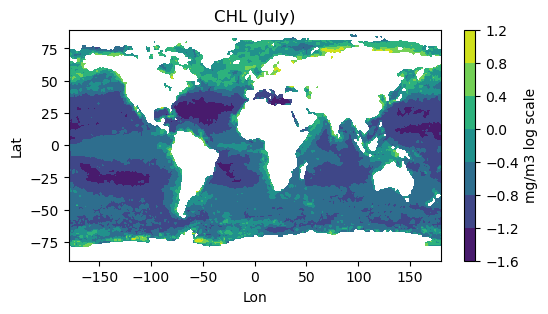

In [67]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.contourf(ideal_grid.longitude,ideal_grid.latitude,np.ma.log10(chl_out.chl[12*20+6,:,:]))  #just one summer month; log scale to make more readable
plt.title('CHL (July)'); plt.xlabel('Lon'); plt.ylabel('Lat')
plt.colorbar().set_label('mg/m3 log scale');